Import all the required libraries

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
# from azure.storage.blob import BlobServiceClient
# from datetime import datetime, timedelta
#
# # ------------------------------------------------------------
# # Azure Blob Storage Connection Setup
# # ------------------------------------------------------------
#
# connection_string = "DefaultEndpointsProtocol=https;AccountName=insurancedata;..."


Loading and merging the files


In [139]:
claims_file = 'claims_sample.csv'
policies_file = 'policies_sample.csv'
customers_file = 'customers_sample.csv'

try:
    claims_df = pd.read_csv(claims_file)
    policies_df = pd.read_csv(policies_file)   
    customers_df = pd.read_csv(customers_file)
    print("Data loaded successfully!!")

except FileNotFoundError as e:
    print(f"File not found: {e}")
    exit(1)

merged_df = pd.merge(claims_df, policies_df, on='policy_id', how='left')
merged_df = pd.merge(merged_df, customers_df, on='customer_id', how='left')

merged_df.head()

Data loaded successfully!!


,claim_id,policy_id,policy_number_x,claim_date,claim_amount,claim_type,status_x,customer_id,policy_number_y,policy_type,annual_premium,coverage_amount,start_date,status_y,name,age,email,city,registration_date
0,101,244,P1044,2025-02-22,9644.43,MEDICAL,PENDING,29,P1044,LIFE,2275.81,53582.47,2023-07-10,ACTIVE,Daniel Wilson,70,customer29@email.com,Philadelphia,2022-06-16
1,102,203,P1003,2022-10-18,7061.45,FIRE,PENDING,35,P1003,BUSINESS,7113.81,64808.93,2021-08-19,ACTIVE,Kenneth Hall,53,customer35@email.com,Phoenix,2023-11-12
2,103,271,P1071,2022-11-21,17933.97,ACCIDENT,PENDING,35,P1071,HEALTH,3622.71,74642.17,2021-04-06,ACTIVE,Kenneth Hall,53,customer35@email.com,Phoenix,2023-11-12
3,104,230,P1030,2025-05-19,8072.04,OTHER,APPROVED,25,P1030,BUSINESS,6790.51,51012.32,2023-05-28,ACTIVE,Dorothy Jackson,56,customer25@email.com,New York,2023-07-21
4,105,229,P1029,2022-02-20,40902.59,MEDICAL,APPROVED,8,P1029,BUSINESS,7156.02,183797.65,2021-09-11,ACTIVE,Steven Hill,57,customer8@email.com,New York,2020-05-10


Feature Selection

In [140]:

required_columns = [
'claim_id',
'policy_id',         
'policy_number_x',   
'customer_id',
'policy_type',
'start_date',
'claim_date',
'claim_amount',
'coverage_amount',
'registration_date'
]

# Create the new, clean DataFrame with the complete set of columns
analysis_df = merged_df[required_columns].copy()
analysis_df.head()


,claim_id,policy_id,policy_number_x,customer_id,policy_type,start_date,claim_date,claim_amount,coverage_amount,registration_date
0,101,244,P1044,29,LIFE,2023-07-10,2025-02-22,9644.43,53582.47,2022-06-16
1,102,203,P1003,35,BUSINESS,2021-08-19,2022-10-18,7061.45,64808.93,2023-11-12
2,103,271,P1071,35,HEALTH,2021-04-06,2022-11-21,17933.97,74642.17,2023-11-12
3,104,230,P1030,25,BUSINESS,2023-05-28,2025-05-19,8072.04,51012.32,2023-07-21
4,105,229,P1029,8,BUSINESS,2021-09-11,2022-02-20,40902.59,183797.65,2020-05-10


In [141]:
print("--- Dataframe Info ---")
analysis_df.info()

--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   claim_id           120 non-null    int64  
 1   policy_id          120 non-null    int64  
 2   policy_number_x    120 non-null    object 
 3   customer_id        120 non-null    int64  
 4   policy_type        120 non-null    object 
 5   start_date         120 non-null    object 
 6   claim_date         120 non-null    object 
 7   claim_amount       120 non-null    float64
 8   coverage_amount    120 non-null    float64
 9   registration_date  120 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 9.5+ KB


Convert date columns to datetime objects

In [142]:
analysis_df['start_date'] = pd.to_datetime(analysis_df['start_date'], errors="coerce")
analysis_df['claim_date'] = pd.to_datetime(analysis_df['claim_date'], errors="coerce")
analysis_df['registration_date'] = pd.to_datetime(analysis_df['registration_date'], errors="coerce")

Remove rows with invalid dates and logically impossible claims

In [143]:
analysis_df.dropna(subset=['start_date', 'claim_date', 'registration_date'], inplace=True)

impossible_dates = analysis_df[analysis_df['claim_date'] < analysis_df['start_date']]

if not impossible_dates.empty:
    print(f"Found {len(impossible_dates)} claims with impossible dates:")
    print(impossible_dates)
else:
    print("No claims found with a claim_date before the policy start_date.")

No claims found with a claim_date before the policy start_date.


Check for missing values

In [144]:
# Get a count of null (missing) values for each column
print("\n--- Missing Value Count ---")
print(analysis_df.isnull().sum())


--- Missing Value Count ---
claim_id             0
policy_id            0
policy_number_x      0
customer_id          0
policy_type          0
start_date           0
claim_date           0
claim_amount         0
coverage_amount      0
registration_date    0
dtype: int64


Check for any negative values in claim_amount or coverage_amount

In [145]:
negative_amounts = analysis_df[(analysis_df['claim_amount'] < 0) | (analysis_df['coverage_amount'] < 0)]

if not negative_amounts.empty:
    print(f"Found {len(negative_amounts)} claims with negative financial amounts:")
    print(negative_amounts)
else:
    print("No negative financial amounts found.")

No negative financial amounts found.


# Outliers detection using IQR method

In [146]:
analysis_df['is_outlier'] = False

for policy_type in analysis_df['policy_type'].unique():
    
    subset = analysis_df[analysis_df['policy_type'] == policy_type]
    
    q1 = subset['claim_amount'].quantile(0.25)
    q3 = subset['claim_amount'].quantile(0.75)
    
    iqr = q3 - q1
    
    # Define the upper and lower bounds for what is considered a non-outlier
    # Anything outside this range is an outlier.
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    
    # Find the index numbers of the rows that are outliers
    outlier_indices = subset[(subset['claim_amount'] > upper_bound) | (subset['claim_amount'] < lower_bound)].index
    
    # Update our main DataFrame to mark these claims as True in the 'is_outlier' column
    analysis_df.loc[outlier_indices, 'is_outlier'] = True

outlier_count = analysis_df['is_outlier'].sum()
print(f"Found {outlier_count} statistical outliers in the data.")

print("\n--- Sample of Flagged Outliers ---")
analysis_df[analysis_df['is_outlier'] == True].head()

Found 2 statistical outliers in the data.

--- Sample of Flagged Outliers ---


,claim_id,policy_id,policy_number_x,customer_id,policy_type,start_date,claim_date,claim_amount,coverage_amount,registration_date,is_outlier
32,133,253,P1053,26,BUSINESS,2023-03-02,2024-04-08,59164.42,242529.68,2021-08-23,True
61,162,253,P1053,26,BUSINESS,2023-03-02,2023-05-26,63687.04,242529.68,2021-08-23,True


Visulaizing the outliers using Boxplot

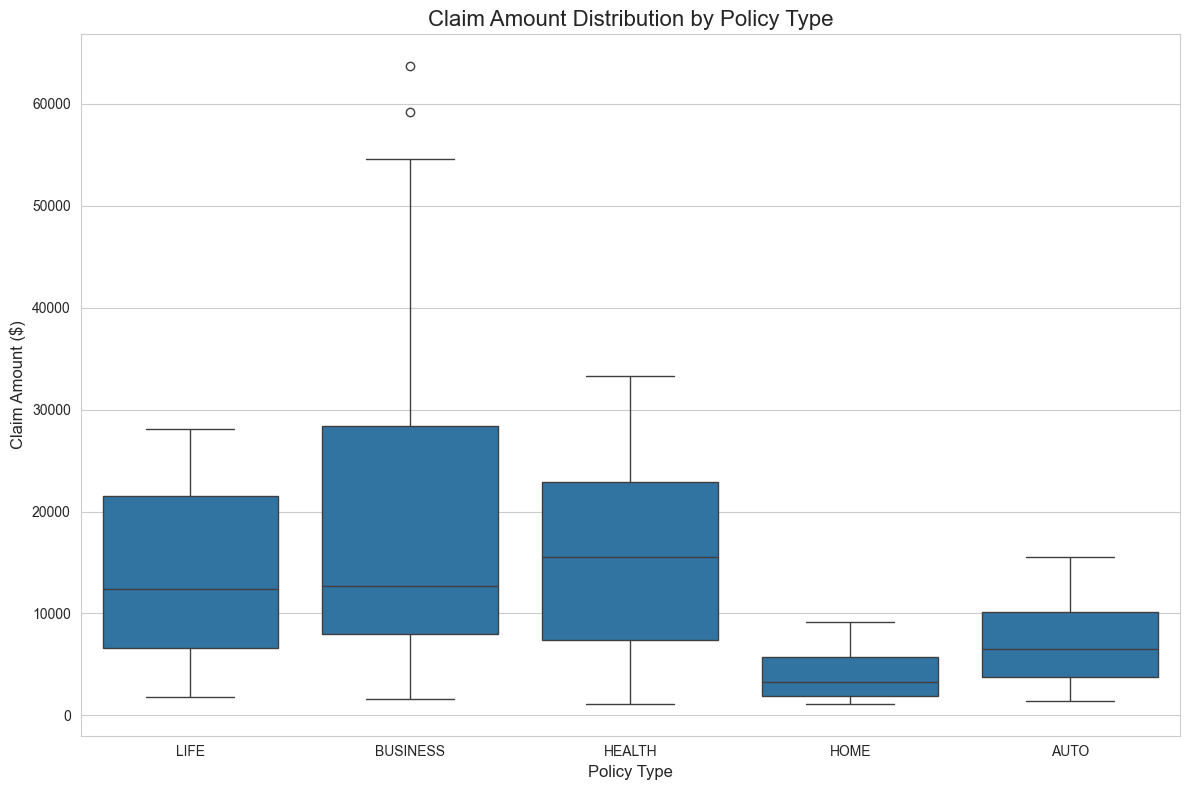

In [147]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='policy_type', y='claim_amount', data=analysis_df)

plt.title('Claim Amount Distribution by Policy Type', fontsize=16)
plt.xlabel('Policy Type', fontsize=12)
plt.ylabel('Claim Amount ($)', fontsize=12)

plt.tight_layout()

# Feature Engineering

In [148]:
# Calculate the difference in days and create a new column
analysis_df['days_to_claim'] = (analysis_df['claim_date'] - analysis_df['start_date']).dt.days

# Divide claim_amount by coverage_amount to get the ratio
analysis_df['coverage_claim_ratio'] = np.where(
    analysis_df['coverage_amount'] > 0,
    analysis_df['claim_amount'] / analysis_df['coverage_amount'],
    np.nan
)

# Sort by customer and date to ensure correct chronological order
analysis_df = analysis_df.sort_values(by=['customer_id', 'claim_date'])

# Group by customer and get a running count of their claims
analysis_df['overall_prior_claims'] = analysis_df.groupby('customer_id').cumcount()

# Claims in Last 365 Days 
def count_rolling_prior_claims(group):
    group = group.sort_values() # Ensure dates within the group are sorted
    return group.apply(lambda date: group[(group < date) & (group >= date - pd.Timedelta(days=365))].count())
claims_last_year = analysis_df.groupby('customer_id')['claim_date'].apply(count_rolling_prior_claims)
analysis_df['claims_in_last_365_days'] = claims_last_year.reset_index(level=0, drop=True)

# Claims Per Year of Service
customer_tenure_years = ((analysis_df['claim_date'] - analysis_df['registration_date']).dt.days + 1) / 365.25
analysis_df['claims_per_year'] = (analysis_df['overall_prior_claims'] + 1) / customer_tenure_years

# Display the first few rows to see the new columns
print("--- DataFrame with All Feature Columns ---")
analysis_df.head()

--- DataFrame with All Feature Columns ---


,claim_id,policy_id,policy_number_x,customer_id,policy_type,start_date,claim_date,claim_amount,coverage_amount,registration_date,is_outlier,days_to_claim,coverage_claim_ratio,overall_prior_claims,claims_in_last_365_days,claims_per_year
29,130,256,P1056,1,HEALTH,2022-08-04,2024-03-02,29430.41,118547.63,2023-12-30,False,576,0.248258,0,0,5.707031
52,153,257,P1057,3,BUSINESS,2023-09-24,2024-02-26,23396.02,121194.54,2022-12-31,False,155,0.193045,0,0,0.863475
72,173,259,P1059,5,LIFE,2022-03-08,2022-11-20,4946.67,27826.73,2023-05-23,False,257,0.177767,0,0,-1.995902
22,123,261,P1061,5,BUSINESS,2023-02-01,2023-11-16,27722.59,102178.72,2023-05-23,False,288,0.271315,1,1,4.103933
24,125,261,P1061,5,BUSINESS,2023-02-01,2024-12-29,10953.53,102178.72,2023-05-23,False,697,0.107200,2,0,1.866695


# Risk Scoring Algorithm


### Risk Scoring Methodology
This scoring system assigns points based on a set of business and statistical rules that are common in insurance fraud detection. Each rule contributes to a total score, which is then normalized to a 0–100 scale for easier interpretation.

#### Rules:

Rapid Claim (< 30 days from policy start) → +40 points
Very early claims are suspicious because most legitimate claims occur after a settling period.

High Claim Ratio (> 80% of coverage amount) → +30 points
A claim amount close to the full coverage value may indicate opportunistic or inflated claims.

Extensive History (> 4 prior claims) → +20 points
Frequent claimants are statistically more likely to file questionable claims.

Statistical Outlier (IQR method) → +10 points
Claims with unusually high amounts compared to similar policies are flagged.

Recent Claim Spike (> 2 claims in last 365 days) → +25 points
Sudden clustering of claims can indicate a high-risk situation.

High Claim Frequency (> 2 claims/year of service) → +15 points
Consistently high claim rates over the policy lifetime are unusual.

These thresholds should be adjusted based on historical data, product type, local regulations, and internal risk tolerance.

In [149]:
if 'anomaly_reasons' in analysis_df.columns:
    analysis_df = analysis_df.drop(columns=['anomaly_reasons'])

analysis_df['risk_score'] = 0
analysis_df['anomaly_reasons'] = ''

# Define Masks for All Scoring Rules
rapid_claim_mask = analysis_df['days_to_claim'] < 30
high_ratio_mask = analysis_df['coverage_claim_ratio'] > 0.80
history_mask = analysis_df['overall_prior_claims'] > 4
outlier_mask = analysis_df['is_outlier'] == True
annual_spike_mask = analysis_df['claims_in_last_365_days'] > 2
frequency_mask = analysis_df['claims_per_year'] > 2

# Apply Scoring and Build Reason String
analysis_df.loc[rapid_claim_mask, 'risk_score'] += 40
analysis_df.loc[rapid_claim_mask, 'anomaly_reasons'] += 'Rapid Claim, '
analysis_df.loc[high_ratio_mask, 'risk_score'] += 30
analysis_df.loc[high_ratio_mask, 'anomaly_reasons'] += 'High Claim Ratio, '
analysis_df.loc[history_mask, 'risk_score'] += 20
analysis_df.loc[history_mask, 'anomaly_reasons'] += 'Extensive History, '
analysis_df.loc[outlier_mask, 'risk_score'] += 10
analysis_df.loc[outlier_mask, 'anomaly_reasons'] += 'Outlier, '
analysis_df.loc[annual_spike_mask, 'risk_score'] += 25
analysis_df.loc[annual_spike_mask, 'anomaly_reasons'] += 'Recent Claim Spike, '
analysis_df.loc[frequency_mask, 'risk_score'] += 15
analysis_df.loc[frequency_mask, 'anomaly_reasons'] += 'High Claim Frequency, '


# NORMALIZE THE FINAL RISK SCORE TO A 0-100 SCALE 
# The maximum possible score is the sum of all points from all rules
max_possible_score = 40 + 30 + 20 + 10 + 25 + 15
# Overwrite the original risk_score with the normalized version
analysis_df['risk_score'] = (analysis_df['risk_score'] / max_possible_score) * 100
analysis_df['risk_score'] = analysis_df['risk_score'].round(2)




# Report

In [150]:
# Clean up the reason strings
analysis_df['anomaly_reasons'] = analysis_df['anomaly_reasons'].str.strip(', ')
analysis_df['anomaly_reasons'] = analysis_df['anomaly_reasons'].replace('', 'No Specific Flags')

# Select and sort the final report
final_report = analysis_df[['claim_id', 'risk_score', 'anomaly_reasons']]
final_report_sorted = final_report.sort_values(by='risk_score', ascending=False)

print("\n--- FINAL ANOMALY DETECTION REPORT ---")
final_report_sorted


--- FINAL ANOMALY DETECTION REPORT ---


,claim_id,risk_score,anomaly_reasons
32,133,50.00,"Extensive History, Outlier, Recent Claim Spike..."
63,164,42.86,"Extensive History, Recent Claim Spike, High Cl..."
115,216,32.14,"Extensive History, Recent Claim Spike"
7,108,32.14,"Extensive History, Recent Claim Spike"
45,146,32.14,"Extensive History, Recent Claim Spike"
...,...,...,...
10,111,0.00,No Specific Flags
21,122,0.00,No Specific Flags
104,205,0.00,No Specific Flags
60,161,0.00,No Specific Flags


In [151]:
print("--- Breakdown of Triggered Rules ---")
print(f"Rapid Claims: {rapid_claim_mask.sum()} claims")
print(f"High Claim Ratio: {high_ratio_mask.sum()} claims")
print(f"Extensive History: {history_mask.sum()} claims")
print(f"Statistical Outliers: {outlier_mask.sum()} claims")
print(f"Recent Claim Spikes: {annual_spike_mask.sum()} claims")
print(f"High Claim Frequency: {frequency_mask.sum()} claims")

--- Breakdown of Triggered Rules ---
Rapid Claims: 0 claims
High Claim Ratio: 0 claims
Extensive History: 16 claims
Statistical Outliers: 2 claims
Recent Claim Spikes: 18 claims
High Claim Frequency: 32 claims


## .txt anomaly detection report

In [152]:
output_filename = "anomaly_report.txt"

report_string = final_report_sorted.to_string()

try:
    with open(output_filename, 'w') as f:
        f.write(report_string)
    print(f"Report successfully saved as a formatted text file: '{output_filename}'")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")


Report successfully saved as a formatted text file: 'anomaly_report.txt'
